# Classification on predicting the water quality based on water properties

# 0. Importing required functions  

In [1]:
# Import pandas that allows us to view and manipulate data
import numpy as np
import pandas as pd

# Import scaler
from sklearn.preprocessing import StandardScaler

# Import datasets(s), and function that allows us to do train-test split
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Import model, and functions to perform model evaluation
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.naive_bayes import GaussianNB

from sklearn.dummy import DummyClassifier

# Import visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

# Changing directory to the folder with the dataset
os.chdir('C:\\SP\\Year 1 Sem 2\\Artificial Intelligence and Machine Learning (AIML)\\CA1\\Datasets')

# 1. Preprocessing the dataset

In [3]:
# loading the dataset into df
df = pd.read_csv('CA1-Classification-Dataset.csv') 

df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Clarity,Quality
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681736,47580.99160,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.80216,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.57822,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.86938,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [4]:
# Show the columns present in the dataset
list(df.columns) 

['ph',
 'Hardness',
 'Solids',
 'Chloramines',
 'Sulfate',
 'Conductivity',
 'Organic_carbon',
 'Trihalomethanes',
 'Clarity',
 'Quality']

### Checking whether the dataset contain any duplicates  

In [5]:
# Check and removing duplicate rows
print("Before dropping duplicates")
print(df.shape)

df = df.drop_duplicates()

print("\nAfter dropping duplicates")
print(df.shape)

Before dropping duplicates
(3276, 10)

After dropping duplicates
(3276, 10)


Since the shape of the dataset didn't change after drop.duplicates, I can safely conclude that there isn't any duplicate data in the dataset.

### Checking if the dataset contain any missing values  

<Axes: >

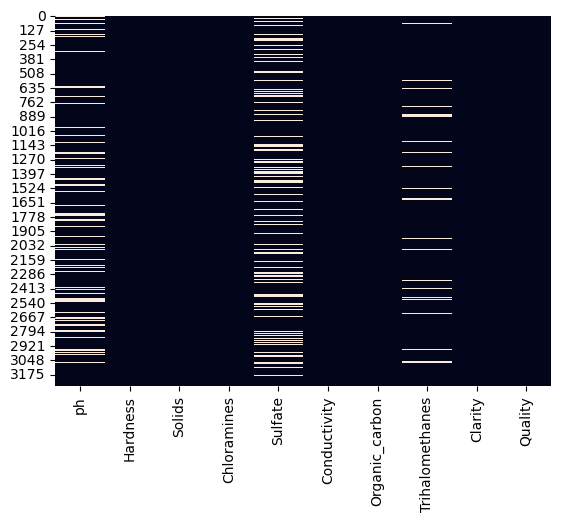

In [6]:
# Heatmap showing missing values(in white)
sns.heatmap(df.isnull(), cbar = False) 

In [7]:
# Sum of total missing values in the data
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Clarity              0
Quality              0
dtype: int64

### Imputing the missing values present using median  

In [8]:
# Filling missing values in 'ph' using the median
median_ph = df['ph'].median()
df['ph'] = df['ph'].fillna(median_ph)

# Filling missing values in 'Sulfate' using the median
median_ph = df['Sulfate'].median()
df['Sulfate'] = df['Sulfate'].fillna(median_ph)

# Filling missing values in 'Trihalomethanes' using the median
median_ph = df['Trihalomethanes'].median()
df['Trihalomethanes'] = df['Trihalomethanes'].fillna(median_ph)

<Axes: >

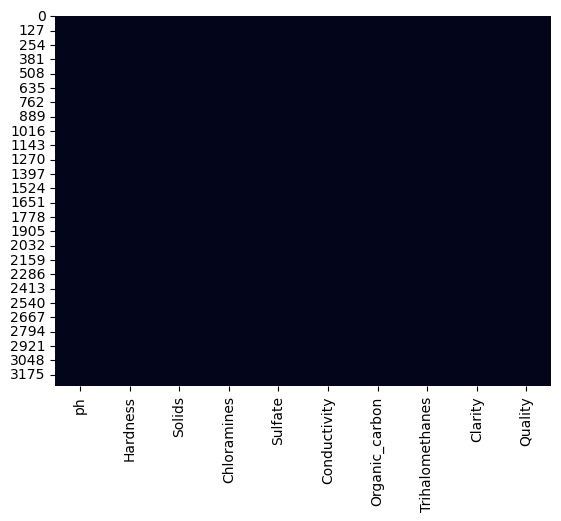

In [9]:
# Checking if there is remaining missing values in the data
sns.heatmap(df.isnull(), cbar = False) 

### Checking for outliers 

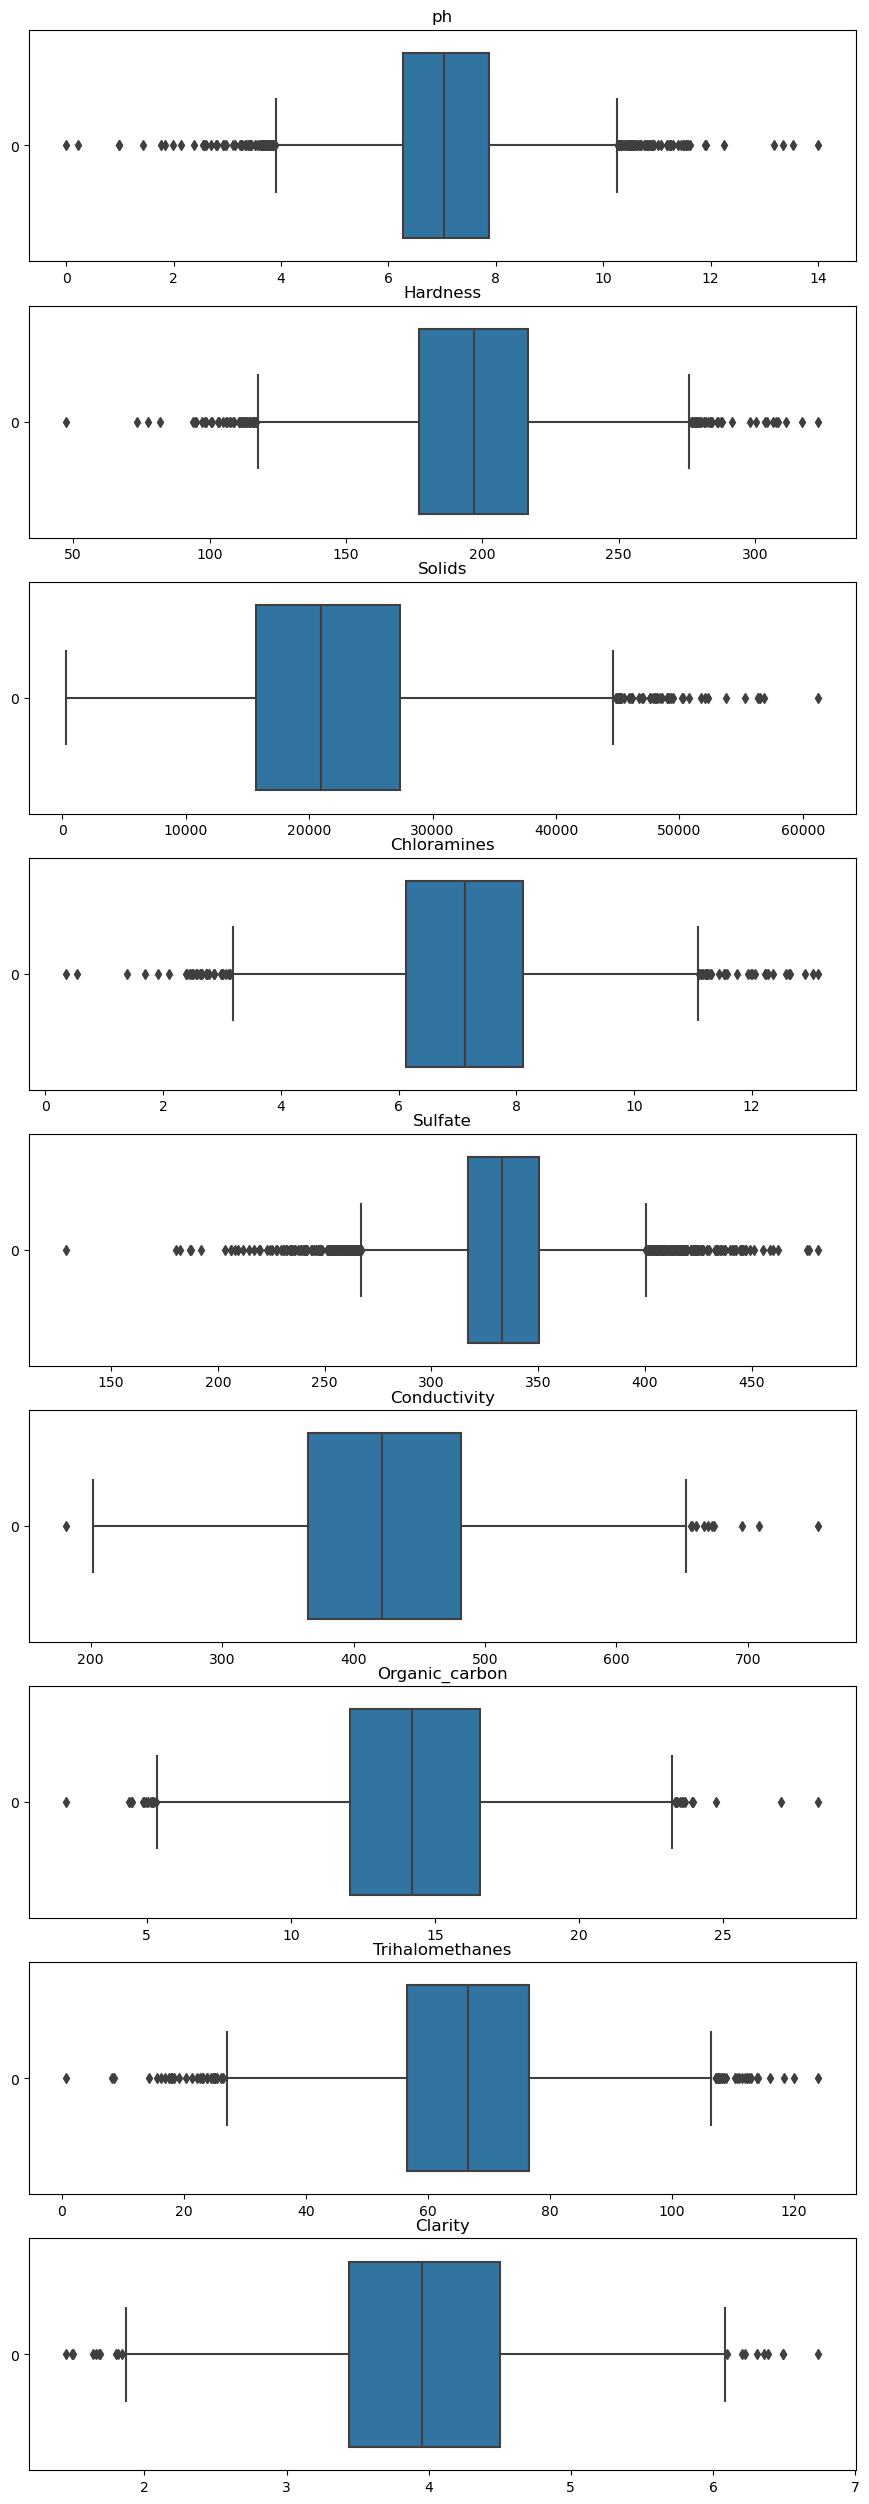

In [10]:
column_list = list(df.drop(['Quality'], axis=1))

# Initializing a figure to store the individual boxplots
fig, axes = plt.subplots(9, figsize=(9,25))
fig.tight_layout()

# Plotting boxplots for all the features in the dataset
index = 0
for column in column_list:
    sns.boxplot(ax=axes[index], data=df[column], orient='h').set_title(column)
    index += 1

After plotting boxplots for all the features present in the dataset, we can identify the outliers by the black diamond markers present outside of the whiskers of the interquartile range. In the above plots, we can see that all features contain outliers, therefore we should find a solution to remove these outliers. The reason why outliers need to be removed is because:
   -  It may cause a significant impact on the mean and the standard deviation. If the outliers are non-randomly distributed, they can decrease normality. They can bias or influence estimates that may be of substantive interest.

### Removing outliers 

Before removing outliers directy from the dataset, I will create a copy of the dataset to allow comparisons between a dataset that the outliers are filtered out, and the original dataset.

In [11]:
# Creating a copy of df
filtered_df = df.copy(deep=True)

filtered_df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Clarity,Quality
0,7.036752,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,333.073546,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,333.073546,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681736,47580.99160,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.80216,8.061362,333.073546,392.449580,19.903225,66.622485,2.798243,1
3273,9.419510,175.762646,33155.57822,7.350233,333.073546,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.86938,6.303357,333.073546,402.883113,11.168946,77.488213,4.708658,1


In [12]:
column_list = list(filtered_df.drop(['Quality'], axis=1))
print(column_list)

print("\nBefore dropping the outliers")
print(filtered_df.shape)

for i in column_list:
    Q1 = filtered_df[i].quantile(0.25)
    Q3 = filtered_df[i].quantile(0.75)
    IQR = Q3 - Q1
    filtered_df = filtered_df[(filtered_df[i] >= Q1 - 1.5 * IQR) & (filtered_df[i] <= Q3 + 1.5 * IQR) | filtered_df[i].isnull()]

print("\nAfter dropping the outliers")
print(filtered_df.shape)

['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Clarity']

Before dropping the outliers
(3276, 10)

After dropping the outliers
(2657, 10)


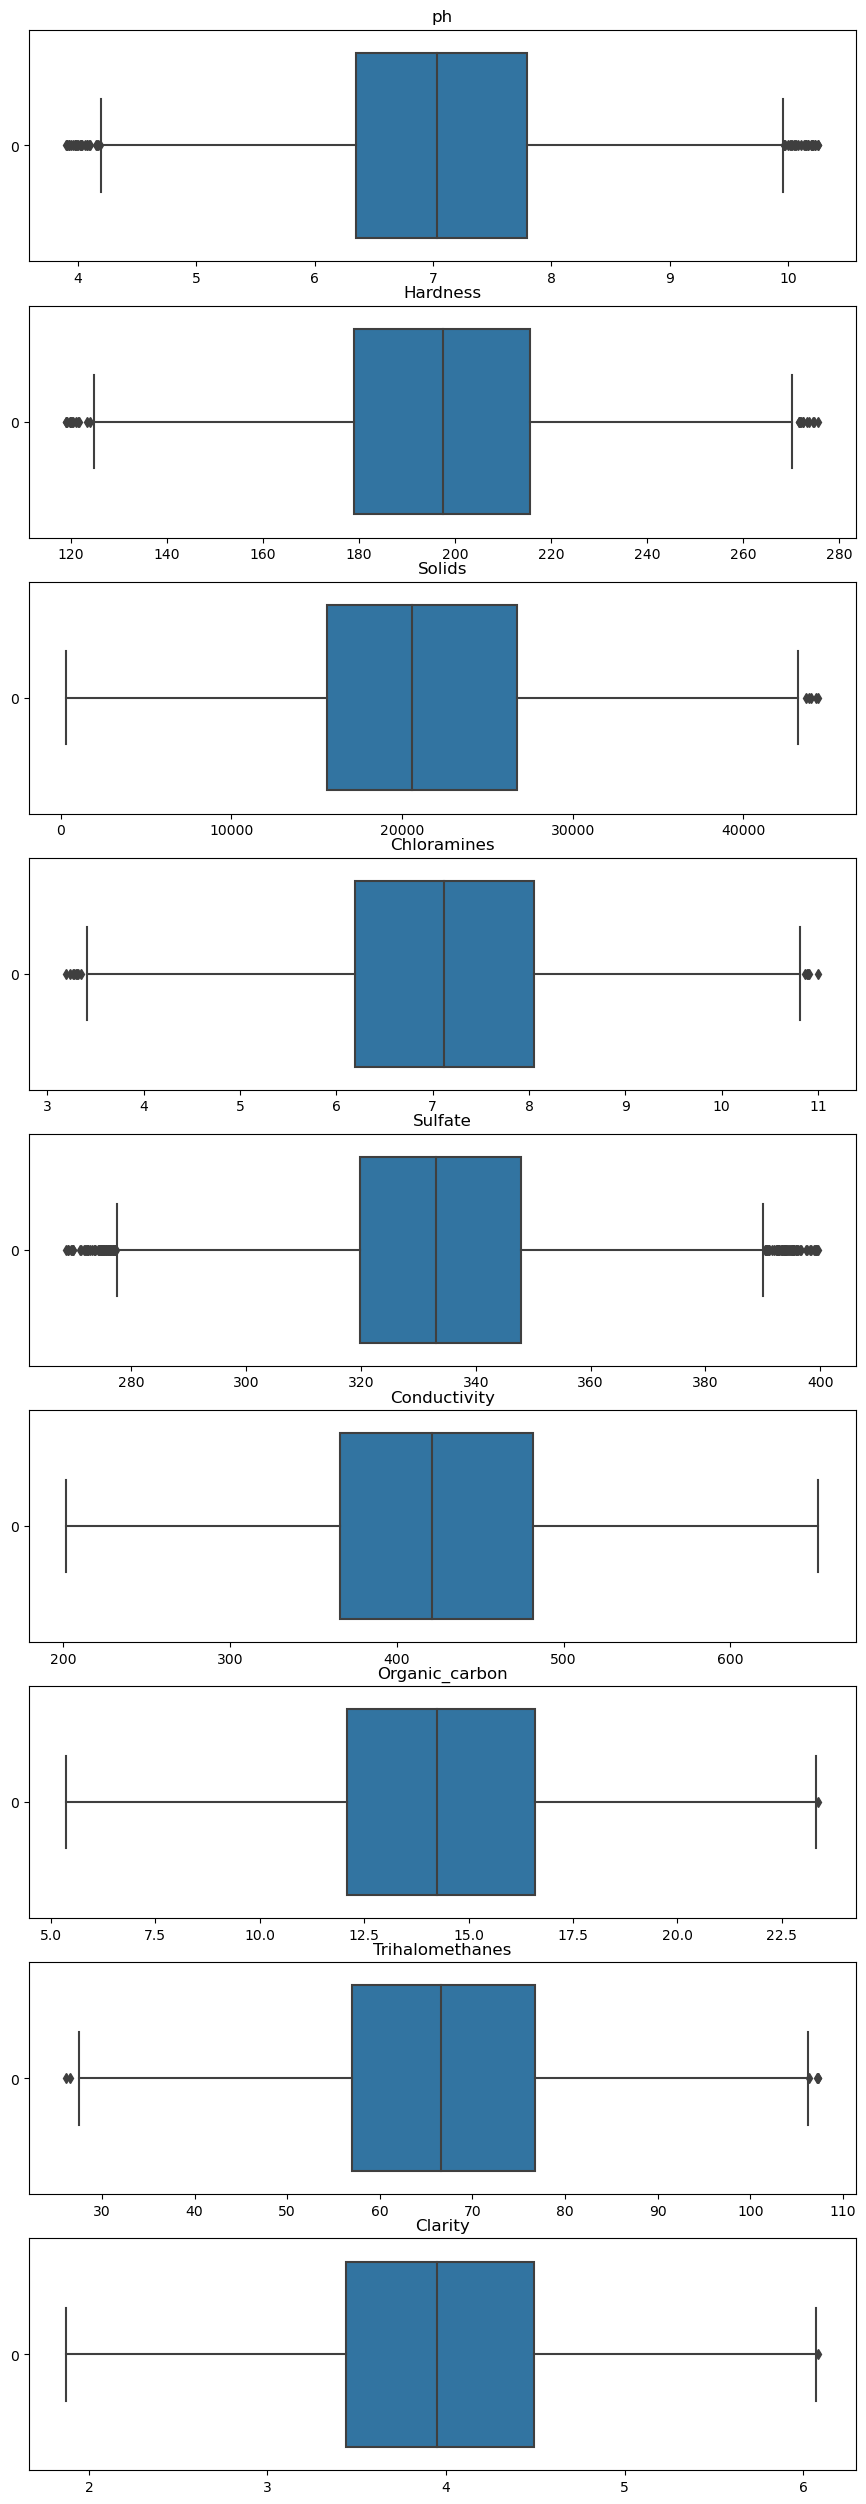

In [13]:
column_list = list(filtered_df.drop(['Quality'], axis=1))

# Initializing a figure to store the individual boxplots
fig, axes = plt.subplots(9, figsize=(9,25))
fig.tight_layout()

# Plotting boxplots for all the features in the dataset
index = 0
for column in column_list:
    sns.boxplot(ax=axes[index], data=filtered_df[column], orient='h').set_title(column)
    index += 1

After removing most of the outliers on the filtered_df dataset, I have:
- orignial df
- filtered_df

# 2. Train-test split 

Since this is a classification problem, only classification models should be chosen, I have chosen the classification models below:
- K-Nearest Neighbors
- Support Vector Classifier (SVC)
- Logistic Regression
- Decision Tree Classifier
- Gaussian Naive Bayes

## (a) Spilting the data into training and testing sets  

In [14]:
# Original df 

X_unfiltered = df.drop(labels="Quality", axis=1)
y_unfiltered = df['Quality']

X_train_unfiltered, X_test_unfiltered, y_train_unfiltered, y_test_unfiltered = train_test_split(X_unfiltered, y_unfiltered, 
                                                   test_size=0.2, 
                                                    random_state=42)

In [15]:
# filtered df 

X_filtered = filtered_df.drop(labels="Quality", axis=1)
y_filtered = filtered_df['Quality']

X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, 
                                                   test_size=0.2, 
                                                    random_state=42)

### Centering and scaling the data

In [16]:
# Scaling on unfiltered data

# Initialize the Standard Scaler
scaler = StandardScaler()

scaled_X_train_unfiltered = scaler.fit_transform(X_train_unfiltered)
scaled_X_test_unfiltered = scaler.transform(X_test_unfiltered)


In [17]:
# Scaling on filtered data

# Initialize the Standard Scaler
scaler = StandardScaler()

scaled_X_train_filtered = scaler.fit_transform(X_train_filtered)
scaled_X_test_filtered = scaler.transform(X_test_filtered)


After preprocessing the dataset (imputing, filtering outliers, scaling the data), I no have the current train-test-split items:

Unfiltered df
- X_train_unfiltered
- scaled_X_train_unfiltered

Filtered df
- X_train_filtered
- scaled_X_train_filtered

# 3. Training and tuning models

In [18]:
# Stratified 5-Folds CV
skf = StratifiedKFold(n_splits = 5) 

I will be using the f1_weighted as my scoring to test and train my models. This is because the dataset has a imbalance data of 0 and 1 in the target column (Quality). If the model decides to predict all values of the majority group, the accuracy or normal f1 score will not be a good representation of how the model actually perform predicting the water quality, thus the weighted f1 score can be better in showing us how well the model is able to predict using the different features given to it despite the imbalance in the target column.

### (i) Training K-Nearest Neighbors

In [19]:
print("K-Nearest Neighbors")

# 1. X_train_unfiltered
KNN_1_scores = cross_val_score(KNeighborsClassifier(), X_train_unfiltered, y_train_unfiltered, cv=skf, scoring = "f1_weighted")
KNN_1_mean_scores = round(KNN_1_scores.mean(), 2)
print(f'X_train_unfiltered Weighted f1 score: ', KNN_1_mean_scores)

# 2. scaled_X_train_unfiltered
KNN_2_scores = cross_val_score(KNeighborsClassifier(), scaled_X_train_unfiltered, y_train_unfiltered, cv=skf, scoring = "f1_weighted")
KNN_2_mean_scores = round(KNN_2_scores.mean(), 2)
print(f'\nscaled_X_train_unfiltered Weighted f1 score: ', KNN_2_mean_scores)

# 3. X_train_filtered
KNN_3_scores = cross_val_score(KNeighborsClassifier(), X_train_filtered, y_train_filtered, cv=skf, scoring = "f1_weighted")
KNN_3_mean_scores = round(KNN_3_scores.mean(), 2)
print(f'\nX_train_filtered Weighted f1 score: ', KNN_3_mean_scores)

# 4. scaled_X_train_filtered
KNN_4_scores = cross_val_score(KNeighborsClassifier(), scaled_X_train_filtered, y_train_filtered, cv=skf, scoring = "f1_weighted")
KNN_4_mean_scores = round(KNN_4_scores.mean(), 2)
print(f'\nscaled_X_train_filtered Weighted f1 score: ', KNN_4_mean_scores)

K-Nearest Neighbors
X_train_unfiltered Weighted f1 score:  0.54

scaled_X_train_unfiltered Weighted f1 score:  0.61

X_train_filtered Weighted f1 score:  0.54

scaled_X_train_filtered Weighted f1 score:  0.57


K-Nearest Neighbors - scaled_X_train_unfiltered  

### Tuning the hyperparameters of K-Nearest Neighbors 

In [20]:
# set the range of k hyperparameters to test, and ran a for loop to find the best k within this range
k_values = range(1, 100) 
mean_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, scaled_X_train_unfiltered, y_train_unfiltered, cv=skf, scoring = "f1_weighted")
    mean_scores.append(np.mean(scores))
    
# find the optimal k
optimal_k= k_values[np.argmax(mean_scores)]
print(f'Optimal k: {optimal_k}')

Optimal k: 5


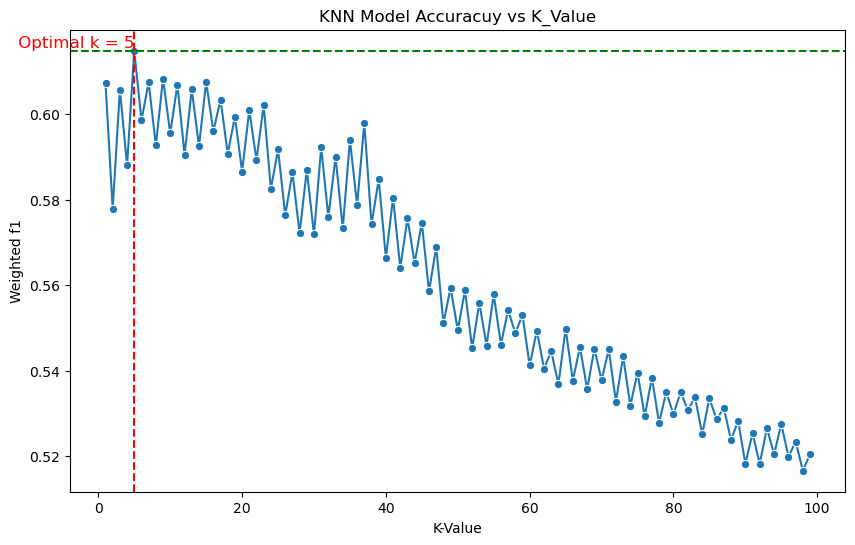

In [21]:
# basic line plot
plt.figure(figsize = (10, 6))
sns.lineplot(x=k_values, y=mean_scores, marker="o")
plt.title("KNN Model Accuracuy vs K_Value")
plt.xlabel("K-Value")
plt.ylabel("Weighted f1")
# Graph to show how k affects the model's weighted f1 

# highlighting the optimal k
plt.axvline(optimal_k, color="red", linestyle="--")
plt.axhline(max(mean_scores), color="green", linestyle="--")
plt.text(optimal_k, max(mean_scores), f" Optimal k = {optimal_k}", verticalalignment="bottom",
         horizontalalignment="right", color="red", fontsize=12)
# Marking k when the model's weighted f1 is the highest

plt.show()

This graph suggests that the best optimal k is 5, where it produces the highest weighted f1 score.

In [22]:
# Fitting and training the base model
base_KNN_scores = cross_val_score(KNeighborsClassifier(), scaled_X_train_unfiltered, y_train_unfiltered, cv=skf, scoring = "f1_weighted")

# Calculating the results
base_KNN_mean_scores = round(base_KNN_scores.mean(), 3)
print(f'Base K-Nearest Neighbors Average Weighted f1 Score: ', base_KNN_mean_scores)

# ------------------------------------------------------------------------------------

# Fitting and training the actual model
tuned_KNN_model = KNeighborsClassifier(n_neighbors=optimal_k)

tuned_KNN_scores = cross_val_score(tuned_KNN_model, scaled_X_train_unfiltered, y_train_unfiltered, cv=skf, scoring = "f1_weighted")

# Calculating the results
tuned_KNN_mean_scores = round(tuned_KNN_scores.mean(), 3)
print(f'\nTuned K-Nearest Neighbors Average Weighted f1 Score: ', tuned_KNN_mean_scores)

Base K-Nearest Neighbors Average Weighted f1 Score:  0.615

Tuned K-Nearest Neighbors Average Weighted f1 Score:  0.615


Best K-Nearest Neighbors model: Tuned/Base K-Nearest Neighbors - 0.62

### (ii) Training Logistic Regression

In [23]:
print("Logistic Regression")

# 1. X_train_unfiltered
LR_1_scores = cross_val_score(LogisticRegression(), X_train_unfiltered, y_train_unfiltered, cv=skf, scoring = "f1_weighted")
LR_1_mean_scores = round(LR_1_scores.mean(), 2)
print(f'X_train_unfiltered Weighted f1 Score: ', LR_1_mean_scores)

# 2. scaled_X_train_unfiltered
LR_2_scores = cross_val_score(LogisticRegression(), scaled_X_train_unfiltered, y_train_unfiltered, cv=skf, scoring = "f1_weighted")
LR_2_mean_scores = round(LR_2_scores.mean(), 2)
print(f'\nscaled_X_train_unfiltered Weighted f1 Score: ', LR_2_mean_scores)

# 3. X_train_filtered
LR_3_scores = cross_val_score(LogisticRegression(), X_train_filtered, y_train_filtered, cv=skf, scoring = "f1_weighted")
LR_3_mean_scores = round(LR_3_scores.mean(), 3)
print(f'\nX_train_filtered Weighted f1 Score: ', LR_3_mean_scores)

# 4. scaled_X_train_filtered
LR_4_scores = cross_val_score(LogisticRegression(), scaled_X_train_filtered, y_train_filtered, cv=skf, scoring = "f1_weighted")
LR_4_mean_scores = round(LR_4_scores.mean(), 3)
print(f'\nscaled_X_train_filtered Weighted f1 Score: ', LR_4_mean_scores)

Logistic Regression
X_train_unfiltered Weighted f1 Score:  0.46

scaled_X_train_unfiltered Weighted f1 Score:  0.46

X_train_filtered Weighted f1 Score:  0.474

scaled_X_train_filtered Weighted f1 Score:  0.474


Logistic Regression - scaled_X_train_filtered 

### Tuning the hyperparameters of Logistic Regression 

In [24]:
# Initializing the LogisticRegression model
LR_model = LogisticRegression()

# Create the parameter space
params = {"penalty": ["l1", "l2"],
         "tol": np.linspace(0.0001, 1.0, 50),
         "C": np.linspace(0.1, 1, 50),
         "class_weight": ["balanced", {0:0.8, 1:0.2}]}

# Instantiate the RandomizedSearchCV object
LR_model_cv = RandomizedSearchCV(LR_model, params, cv=skf, scoring = "f1_weighted", random_state=42)

# Fit the data to the model
LR_model_cv.fit(scaled_X_train_filtered, y_train_filtered)


# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(LR_model_cv.best_params_)) 
# Best parameters to fit the Logistic Regression model

print("\nTuned Logistic Regression Best Weighted f1 score: {}".format(LR_model_cv.best_score_)) 


Tuned Logistic Regression Parameters: {'tol': 0.4082224489795918, 'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.7612244897959184}

Tuned Logistic Regression Best Weighted f1 score: 0.5053601648921343


In [25]:
# Fitting and training the base model
base_LR_scores = cross_val_score(LogisticRegression(), scaled_X_train_filtered, y_train_filtered, cv=skf, scoring = "f1_weighted")

# Calculating the results
base_LR_mean_scores = round(base_LR_scores.mean(), 2)
print(f'Base Logistic Regression Average Weighted f1 Score: ', base_LR_mean_scores)

# --------------------------------------------------------------------------------

# Fitting and training the actual model
tuned_LR_model = LogisticRegression(tol= 0.4082224489795918, 
                              penalty='l2', 
                              class_weight= 'balanced', 
                              C= 0.7612244897959184)

tuned_LR_scores = cross_val_score(tuned_LR_model, scaled_X_train_filtered, y_train_filtered, cv=skf, scoring = "f1_weighted")

# Calculating the results
tuned_LR_mean_scores = round(tuned_LR_scores.mean(), 2)
print(f'\nTuned Logistic Regression Average Weighted f1 Score: ', tuned_LR_mean_scores)

Base Logistic Regression Average Weighted f1 Score:  0.47

Tuned Logistic Regression Average Weighted f1 Score:  0.51


Best Logistic Regression model: Tuned Logistic Regression - 0.51

### (iii) Training Naive Bayes

In [26]:
print("Naive Bayes")

# 1. X_train_unfiltered
NB_1_scores = cross_val_score(GaussianNB(), X_train_unfiltered, y_train_unfiltered, cv=skf, scoring = "f1_weighted")
NB_1_mean_scores = round(NB_1_scores.mean(), 3)
print(f'X_train_unfiltered Weighted f1 Score: ', NB_1_mean_scores)

# 2. scaled_X_train_unfiltered
NB_2_scores = cross_val_score(GaussianNB(), scaled_X_train_unfiltered, y_train_unfiltered, cv=skf, scoring = "f1_weighted")
NB_2_mean_scores = round(NB_2_scores.mean(), 3)
print(f'\nscaled_X_train_unfiltered Weighted f1 Score: ', NB_2_mean_scores)

# 3. X_train_filtered
NB_3_scores = cross_val_score(GaussianNB(), X_train_filtered, y_train_filtered, cv=skf, scoring = "f1_weighted")
NB_3_mean_scores = round(NB_3_scores.mean(), 2)
print(f'\nX_train_filtered Weighted f1 Score: ', NB_3_mean_scores)

# 4. scaled_X_train_filtered
NB_4_scores = cross_val_score(GaussianNB(), scaled_X_train_filtered, y_train_filtered, cv=skf, scoring = "f1_weighted")
NB_4_mean_scores = round(NB_4_scores.mean(), 2)
print(f'\nscaled_X_train_filtered Weighted f1 Score: ', NB_4_mean_scores)

Naive Bayes
X_train_unfiltered Weighted f1 Score:  0.575

scaled_X_train_unfiltered Weighted f1 Score:  0.576

X_train_filtered Weighted f1 Score:  0.53

scaled_X_train_filtered Weighted f1 Score:  0.53


Naive Bayes - scaled_X_train_unfiltered 

### Tuning the hyperparameters of Naive Bayes 

In [27]:
# Initializing the Naive Bayes model
NB_model = GaussianNB()

# Create the parameter space
params = {'var_smoothing': np.logspace(0, -9, num=100)}

# Instantiate the GridSearchCV object
NB_model_cv = GridSearchCV(NB_model, params, cv=skf, scoring = "f1_weighted")

# Fit the data to the model
NB_model_cv.fit(scaled_X_train_unfiltered, y_train_unfiltered)


# Print the tuned parameters and score
print("Tuned Naive Bayes Parameters: {}".format(NB_model_cv.best_params_)) 
# Best parameters to fit the Naive Bayes model

print("\nTuned Naive Bayes Best f1 score: {}".format(NB_model_cv.best_score_))

Tuned Naive Bayes Parameters: {'var_smoothing': 0.0015199110829529332}

Tuned Naive Bayes Best f1 score: 0.5759258025287786


In [28]:
# Fitting and training the base model
base_NB_scores = cross_val_score(GaussianNB(), scaled_X_train_unfiltered, y_train_unfiltered, cv=skf, scoring = "f1_weighted")

# Calculating the results
base_NB_mean_scores = round(base_NB_scores.mean(), 3)
print(f'Base Naive Bayes Average Weighted f1 Score: ', base_NB_mean_scores)

# ----------------------------------------------------------------------------------

# Fitting and training the actual model
tuned_NB_model = GaussianNB(var_smoothing = 0.0015199110829529332)

tuned_NB_scores = cross_val_score(tuned_NB_model, scaled_X_train_unfiltered, y_train_unfiltered, cv=skf, scoring = "f1_weighted")

# Calculating the results
tuned_NB_mean_scores = round(tuned_NB_scores.mean(), 3)
print(f'\nTuned Naive Bayes Average Weighted f1 Score: ', tuned_NB_mean_scores)

Base Naive Bayes Average Weighted f1 Score:  0.576

Tuned Naive Bayes Average Weighted f1 Score:  0.576


Best Naive Bayes model: Base/Tuned Naive Bayes - 0.576

### (iv) Training Support Vector Classifier (SVC)

In [29]:
print("Support Vector Classifier (SVC)")

# 1. X_train_unfiltered
SVC_1_scores = cross_val_score(SVC(), X_train_unfiltered, y_train_unfiltered, cv=skf, scoring = "f1_weighted")
SVC_1_mean_scores = round(SVC_1_scores.mean(), 2)
print(f'X_train_unfiltered Weighted f1 Score: ', SVC_1_mean_scores)

# 2. scaled_X_train_unfiltered
SVC_2_scores = cross_val_score(SVC(), scaled_X_train_unfiltered, y_train_unfiltered, cv=skf, scoring = "f1_weighted")
SVC_2_mean_scores = round(SVC_2_scores.mean(), 2)
print(f'\nscaled_X_train_unfiltered Weighted f1 Score: ', SVC_2_mean_scores)

# 3. X_train_filtered
SVC_3_scores = cross_val_score(SVC(), X_train_filtered, y_train_filtered, cv=skf, scoring = "f1_weighted")
SVC_3_mean_scores = round(SVC_3_scores.mean(), 2)
print(f'\nX_train_filtered Weighted f1 Score: ', SVC_3_mean_scores)

# 4. scaled_X_train_filtered
SVC_4_scores = cross_val_score(SVC(), scaled_X_train_filtered, y_train_filtered, cv=skf, scoring = "f1_weighted")
SVC_4_mean_scores = round(SVC_4_scores.mean(), 2)
print(f'\nscaled_X_train_filtered Weighted f1 Score: ', SVC_4_mean_scores)

Support Vector Classifier (SVC)
X_train_unfiltered Weighted f1 Score:  0.46

scaled_X_train_unfiltered Weighted f1 Score:  0.63

X_train_filtered Weighted f1 Score:  0.47

scaled_X_train_filtered Weighted f1 Score:  0.6


Support Vector Classifier (SVC) - scaled_X_train_unfiltered

### Tuning the hyperparameters of SVC

In [30]:
# Initializing the SVC model
SVC_model = SVC()

param_grid = {'C': np.linspace(0.01, 5, 100),
         'gamma': np.linspace(0.01, 1, 200)}

# Instantiate the RandomizedSearchCV object
SVC_model_cv = RandomizedSearchCV(SVC_model, param_grid, cv=skf, n_jobs=-1, scoring = "f1_weighted", random_state=42)

# Fit the data to the model
SVC_model_cv.fit(scaled_X_train_unfiltered, y_train_unfiltered)


# Print the tuned parameters and score
print("Tuned SVC Parameters: {}".format(SVC_model_cv.best_params_)) 
# Best parameters to fit the SVC model

print("\nTuned SVC Best f1 score: {}".format(SVC_model_cv.best_score_)) 

Tuned SVC Parameters: {'gamma': 0.12442211055276382, 'C': 3.639090909090909}

Tuned SVC Best f1 score: 0.662981388327327


In [31]:
# Fitting and training the base model
base_SVC_scores = cross_val_score(SVC(), scaled_X_train_unfiltered, y_train_unfiltered, cv=skf, scoring = "f1_weighted")

# Calculating the results
base_SVC_mean_scores = round(base_SVC_scores.mean(), 2)
print(f'Base SVC Average Weighted f1 Score: ', base_SVC_mean_scores)

# ----------------------------------------------------------------------------------

# Fitting and training the actual model
tuned_SVC_model = SVC(gamma = 0.12442211055276382, 
                      C = 3.639090909090909)

tuned_SVC_scores = cross_val_score(tuned_SVC_model, scaled_X_train_unfiltered, y_train_unfiltered, cv=skf, scoring = "f1_weighted")

# Calculating the results
tuned_SVC_mean_scores = round(tuned_SVC_scores.mean(), 2)
print(f'\nTuned SVC Average Weighted f1 Score: ', tuned_SVC_mean_scores)

Base SVC Average Weighted f1 Score:  0.63

Tuned SVC Average Weighted f1 Score:  0.66


Best SVC model: Tuned SVC - 0.66

### (v) Training Decision Tree

In [32]:
print("Decision Tree Classifier")

# 1. X_train_unfiltered
DT_1_scores = cross_val_score(DecisionTreeClassifier(), X_train_unfiltered, y_train_unfiltered, cv=skf, scoring = "f1_weighted")
DT_1_mean_scores = round(DT_1_scores.mean(), 3)
print(f'X_train_unfiltered Weighted f1 Score: ', DT_1_mean_scores)

# 2. scaled_X_train_unfiltered
DT_2_scores = cross_val_score(DecisionTreeClassifier(), scaled_X_train_unfiltered, y_train_unfiltered, cv=skf, scoring = "f1_weighted")
DT_2_mean_scores = round(DT_2_scores.mean(), 3)
print(f'\nscaled_X_train_unfiltered Weighted f1 Score: ', DT_2_mean_scores)

# 3. X_train_filtered
DT_3_scores = cross_val_score(DecisionTreeClassifier(), X_train_filtered, y_train_filtered, cv=skf, scoring = "f1_weighted")
DT_3_mean_scores = round(DT_3_scores.mean(), 2)
print(f'\nX_train_filtered Weighted f1 Score: ', DT_3_mean_scores)

# 4. scaled_X_train_filtered
DT_4_scores = cross_val_score(DecisionTreeClassifier(), scaled_X_train_filtered, y_train_filtered, cv=skf, scoring = "f1_weighted")
DT_4_mean_scores = round(DT_4_scores.mean(), 2)
print(f'\nscaled_X_train_filtered Weighted f1 Score: ', DT_4_mean_scores)

Decision Tree Classifier
X_train_unfiltered Weighted f1 Score:  0.566

scaled_X_train_unfiltered Weighted f1 Score:  0.571

X_train_filtered Weighted f1 Score:  0.56

scaled_X_train_filtered Weighted f1 Score:  0.56


Decision Tree Classifier - scaled_X_train_unfiltered

### Tuning the hyperparameters of Decision Tree Classifier  

In [33]:
# Initializing the DT model
DT_model = DecisionTreeClassifier()

param_grid = {'criterion':['gini','entropy'],
              'max_depth':np.arange(1,21).tolist(),
              'min_samples_split':np.arange(2,11).tolist(),
              'max_leaf_nodes':np.arange(3,26).tolist()
             }

# Instantiate the RandomizedSearchCV object
DT_model_cv = RandomizedSearchCV(DT_model, param_grid, cv=skf, scoring = "f1_weighted", random_state=42)

# Fit the data to the model
DT_model_cv.fit(scaled_X_train_unfiltered, y_train_unfiltered)


# Print the tuned parameters and score
print("Tuned DT Parameters: {}".format(DT_model_cv.best_params_)) 
# Best parameters to fit the SVC model

print("\nTuned DT Best f1 score: {}".format(DT_model_cv.best_score_)) 

Tuned DT Parameters: {'min_samples_split': 9, 'max_leaf_nodes': 5, 'max_depth': 16, 'criterion': 'entropy'}

Tuned DT Best f1 score: 0.5837939809671321


In [34]:
# Fitting and training the base model
base_DT_scores = cross_val_score(DecisionTreeClassifier(), X_train_unfiltered, y_train_unfiltered, cv=skf, scoring = "f1_weighted")

# Calculating the results
base_DT_mean_scores = round(base_DT_scores.mean(), 2)
print(f'Base Decision Tree Average Weighted f1 Score: ', base_DT_mean_scores)

# -------------------------------------------------------------------------------------

# Fitting and training the actual model
tuned_DT_model = DecisionTreeClassifier(min_samples_split = 9, 
                      max_leaf_nodes = 5, 
                      max_depth = 16, 
                      criterion = 'entropy')

tuned_DT_scores = cross_val_score(tuned_DT_model, X_train_unfiltered, y_train_unfiltered, cv=skf, scoring = "f1_weighted")

# Calculating the results
tuned_DT_mean_scores = round(tuned_DT_scores.mean(), 2)
print(f'\nTuned Decision Tree Average Weighted f1 Score: ', tuned_DT_mean_scores)

Base Decision Tree Average Weighted f1 Score:  0.58

Tuned Decision Tree Average Weighted f1 Score:  0.58


Best Decision Tree model: Tuned Decision Tree - 0.58

# 4. Evaluating the results

## (a) Comparing models

In [35]:
print("------ Model's results ------")
print(f'Tuned K-Nearest Neighbors Average Weighted f1 Score: ', round(tuned_KNN_mean_scores, 2))
print(f'\nTuned Logistic Regression Average Weighted f1 Score: ', round(tuned_LR_mean_scores, 2))
print(f'\nTuned Naive Bayes Average Weighted f1 Score: ', round(tuned_NB_mean_scores, 2))
print(f'\nTuned SVC Average Weighted f1 Score: ', round(tuned_SVC_mean_scores, 2))
print(f'\nTuned Decision Tree Average Weighted f1 Score: ', round(tuned_DT_mean_scores, 2))

------ Model's results ------
Tuned K-Nearest Neighbors Average Weighted f1 Score:  0.62

Tuned Logistic Regression Average Weighted f1 Score:  0.51

Tuned Naive Bayes Average Weighted f1 Score:  0.58

Tuned SVC Average Weighted f1 Score:  0.66

Tuned Decision Tree Average Weighted f1 Score:  0.58


Best Model: SVC (Tuned) - 0.66

## (b) Creating dummy baseline 

In [36]:
# Initializing the Dummy Classifier model
dummy_model = DummyClassifier()

param_grid = {'strategy': ["most_frequent", "prior", "stratified", "uniform", "constant"]}

# Instantiate the GridSearchCV object
dummy_model_cv = GridSearchCV(dummy_model, param_grid, cv=skf)

# Fit the data to the model
dummy_model_cv.fit(X_train_unfiltered, y_train_unfiltered)

# Best parameters to fit the SVC model
print("Tuned Dummy Classifier Parameters: {}".format(dummy_model_cv.best_params_)) 

Tuned Dummy Classifier Parameters: {'strategy': 'most_frequent'}


In [37]:
# Fitting and training the base model
base_dummy_scores = cross_val_score(DummyClassifier(), X_train_unfiltered, y_train_unfiltered, cv=skf, scoring = "f1_weighted")

# Calculating the results
base_dummy_mean_scores = round(base_dummy_scores.mean(), 2)
print(f'Dummy Classifier Average Weighted f1 Score: ', base_dummy_mean_scores)

# -------------------------------------------------------------------------------------

# Fitting and training the actual model

tuned_dummy_model = DummyClassifier(strategy = 'most_frequent')

tuned_dummy_scores = cross_val_score(tuned_dummy_model, X_train_unfiltered, y_train_unfiltered, cv=skf, scoring = "f1_weighted")

# Calculating the results
tuned_dummy_mean_scores = round(tuned_DT_scores.mean(), 2)
print(f'\nTuned Dummy Classifier Average Weighted f1 Score: ', tuned_dummy_mean_scores)

Dummy Classifier Average Weighted f1 Score:  0.46

Tuned Dummy Classifier Average Weighted f1 Score:  0.58


Best Dummy Classifier model: Tuned Dummy Classifier - 0.58

## (c) Comparing the best model with the dummy baseline 

In [38]:
print("------ Dummy baseline ------")
print(f'Tuned Dummy Classifier Average Weighted f1 Score: ', tuned_dummy_mean_scores)

print("\n------ Best Classification Model (SVC) ------")
print(f'Tuned SVC Average Weighted f1 Score: ', tuned_SVC_mean_scores)

------ Dummy baseline ------
Tuned Dummy Classifier Average Weighted f1 Score:  0.58

------ Best Classification Model (SVC) ------
Tuned SVC Average Weighted f1 Score:  0.66


Since Support Vector Classification (SVC) has a higher average weighted f1 score compared to the Dummy Classifier model, I can conclude that this Support Vector Classification (SVC) model is decent at predicted water quality in this dataset.

# 5. Fitting the Final Model

In [39]:
print("Support Vector Classifier (SVC) (Tuned)")

# Fitting the Tuned SVC model 
tuned_SVC_model = SVC(gamma = 0.12442211055276382, 
                      C = 3.639090909090909)
tuned_SVC_model.fit(scaled_X_train_unfiltered, y_train_unfiltered)

tuned_y_test_pred = tuned_SVC_model.predict(scaled_X_test_unfiltered)

tuned_test_weighted_f1 = f1_score(y_test_unfiltered, tuned_y_test_pred, average='weighted')
print(f"\nTest Set Weighted f1: {tuned_test_weighted_f1}")


Support Vector Classifier (SVC) (Tuned)

Test Set Weighted f1: 0.6561973702318893


In [40]:
# Showing the values in the 'Quality' column
data_quality_names = [cls for cls in tuned_SVC_model.classes_] 
print(data_quality_names)

[0, 1]


### Classification Report 

In [41]:
print(classification_report(y_test_unfiltered, tuned_y_test_pred))
# Printing out the main classification metrics of the model after predicting the test set

              precision    recall  f1-score   support

           0       0.71      0.81      0.75       412
           1       0.57      0.43      0.49       244

    accuracy                           0.67       656
   macro avg       0.64      0.62      0.62       656
weighted avg       0.66      0.67      0.66       656



### Confusion Matrix

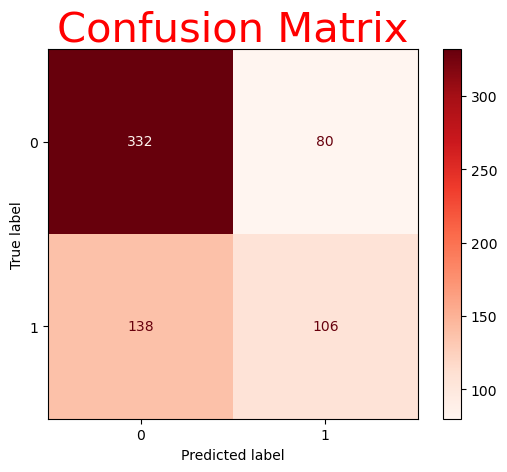

In [42]:
## Assigning what we want as rows and cols in our confusion matrix
actual = y_test_unfiltered
predicted = tuned_y_test_pred
cm = confusion_matrix(actual, predicted)

## Customizing our confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm,
                                   display_labels = data_quality_names)

cm_display.plot(cmap=plt.cm.Reds) 

plt.title('Confusion Matrix'
         ,fontsize = 30
         ,color = 'red') 

plt.show()

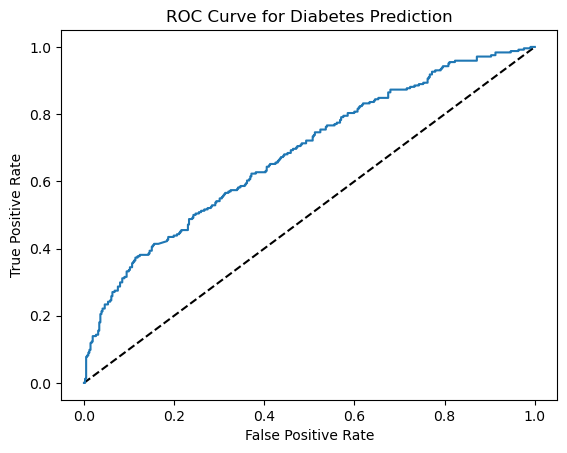

In [43]:
final_SVC_model = SVC(probability=True, 
                      gamma = 0.12442211055276382, 
                      C = 3.639090909090909)


y_pred = final_SVC_model.fit(scaled_X_train_unfiltered, y_train_unfiltered).predict_proba(scaled_X_test_unfiltered)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_unfiltered, y_pred)
# tuned_y_test_pred
plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Diabetes Prediction')
plt.show()